In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

21.8 +/- 1.9
19.2 +/- 1.7


# Do the same for the data after LL round 1

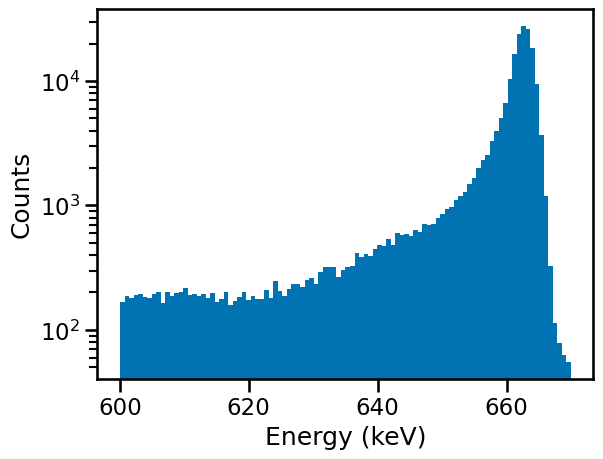

FWHM = 3.42
FWTM = 8.36


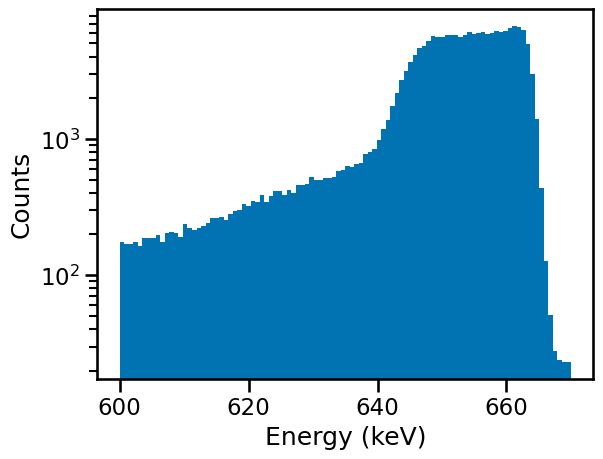

FWHM = 19.23
FWTM = 27.69


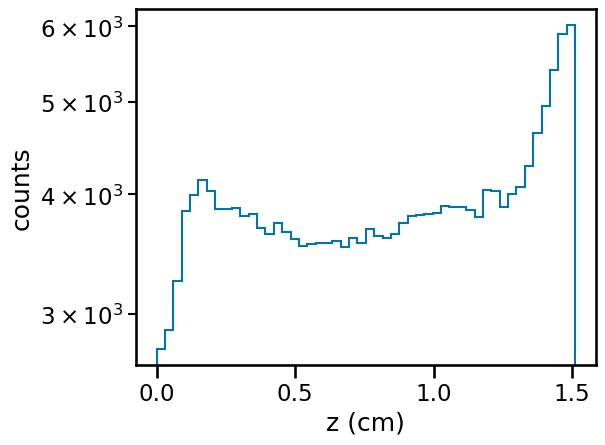

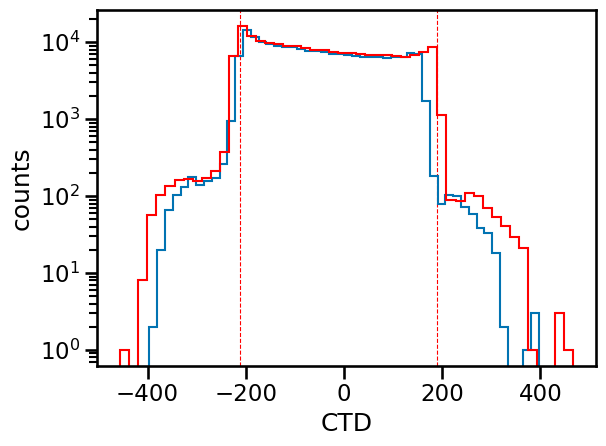

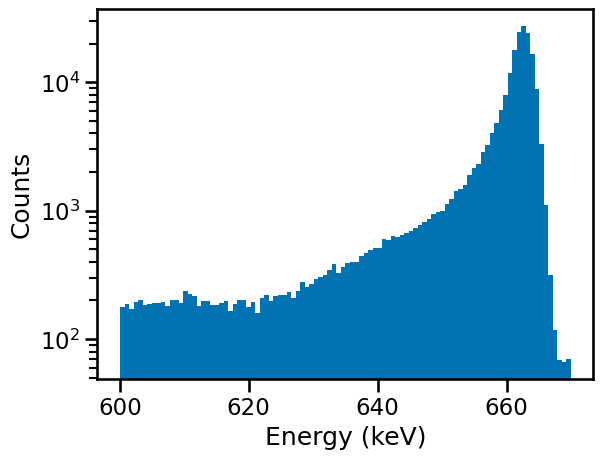

FWHM = 3.51
FWTM = 9.39


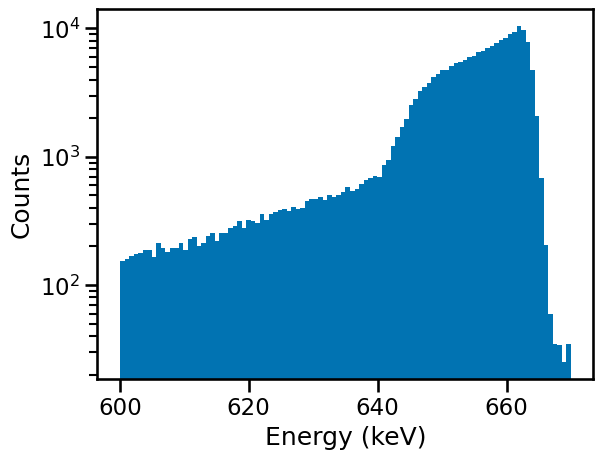

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 12.31
FWTM = 23.27


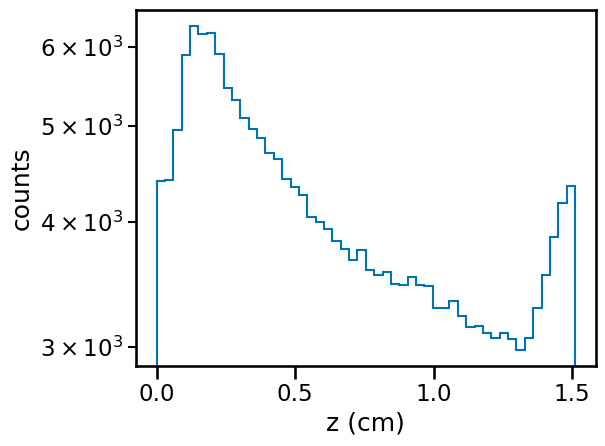

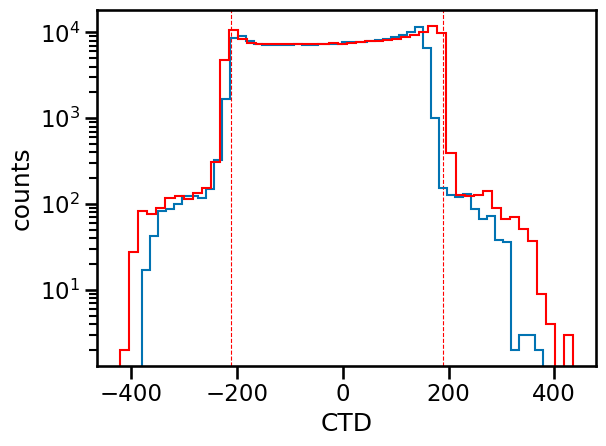

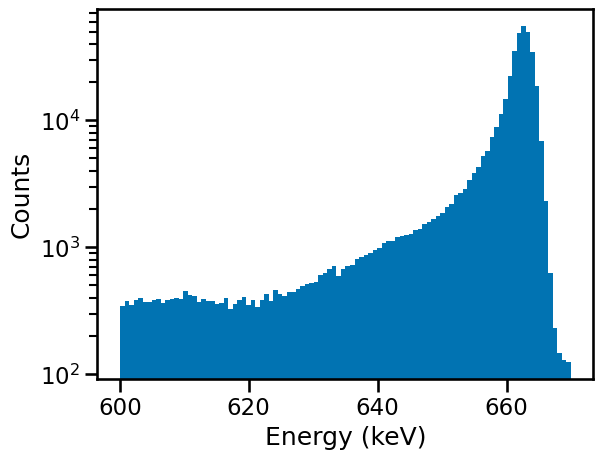

FWHM = 3.47
FWTM = 8.77


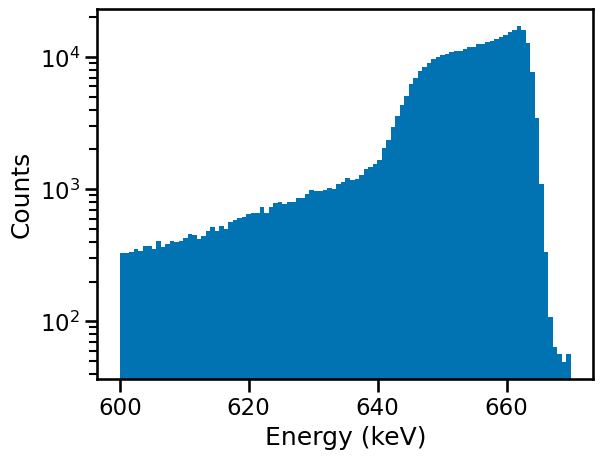

FWHM = 16.45
FWTM = 24.85


In [ ]:
AC_list = ['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat']
DC_list = ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL1', 'allDC_postLL1', 'allACandDC_postLL1']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL1/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL1, h_signal_postLL1 = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [ ]:
depth_correction(df_list[-1], z_list, e_signal_postLL1, h_signal_postLL1, plot_suffix = 'Cs137allACandDC_postLL1')

In [ ]:
fit_CCE(z_list, [e_signal_postLL1[0][3:-3], e_signal_post_LL1[1][3:-3]], [h_signal_postLL1[0][3:-3], h_signal_post_LL1[1][3:-3]], sim_dCCE, plot_suffix = 'Cs137allACandDC_postLL1')